In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
sys.path.append('../ipa/src/')
import preprocessing_utils as pre
import localization_utils as loc
import detection_utils as det
import nd2
import correction_utils as cor
import stackview
from glob import glob
from tqdm import tqdm
import seaborn as sns
from skimage.feature import blob_log


# Open the image

In [3]:
R=np.array([[ 9.99999991e-01, -3.65627251e-05,  1.27041639e-04],
       [ 3.65748625e-05,  9.99999995e-01, -9.55376041e-05],
       [-1.27038146e-04,  9.55422498e-05,  9.99999987e-01]])
displacement=np.array([[ 0.0021868 ],[-0.00220332],[ 0.00194107]])

In [21]:
df_1 = []
df_2 = []
for path in tqdm(glob('/tungstenfs/scratch/ggiorget/nessim/2_color_imaging/localization_precision_estimation/runs/20240503_cells_run_1/matched_detections_channel_*_fitted_20240430_B2_100ms_7%laser_nd_008.nd2.csv')):
    #print(path.split("/"))
    if 'channel_1' in path.split('/')[-1]:
        df_1 = pd.read_csv(path)
    elif 'channel_2' in path.split('/')[-1]:
        df_2 = pd.read_csv(path)
    else:
        raise Exception
    
    frames_1=df_1["frame"].unique()
    frames_2=df_2["frame"].unique()
    for frame in frames_1:
        if frame in frames_2:
            reference = df_1[df_1["frame"].values==frame]["x","y","z"]
            moving = df_2[["x","y","z"]].values.T
            moving_cor = moving#np.dot(R,moving)+displacement
            matched=cor.assign_closest(pd.DataFrame(reference.T,columns=["x","y","z"]),pd.DataFrame(moving_cor.T,columns=["x","y","z"]),0.3)
        else:
            pass

#df_comb = pd.concat(df_comb)

100%|██████████| 2/2 [00:00<00:00, 72.71it/s]


In [27]:
df_1[df_1["frame"].values==1]

,Unnamed: 0,x,y,z,sd_fit_x,sd_fit_y,sd_fit_z,frame,x_um,y_um,z_um
6,0,230.713427,103.528978,7.964520,0.120645,0.114497,0.166915,1,29.992746,13.458767,1.592904
7,2,188.616502,791.485662,12.223228,0.056983,0.071233,0.057783,1,24.520145,102.893136,2.444646
8,4,396.082972,791.652416,12.710165,0.113970,0.093907,0.083433,1,51.490786,102.914814,2.542033
9,8,858.917181,631.354503,11.410984,0.199562,0.170787,0.170295,1,111.659233,82.076085,2.282197
10,10,107.056237,485.991257,2.562466,0.071849,0.072846,0.083591,1,13.917311,63.178863,0.512493


In [252]:
path="/tungstenfs/scratch/ggiorget/kristina/Microscopy/20240502/B2/run_1/20240430_B2_100ms_7%laser_nd_008.nd2"
im = nd2.imread(path)
met = nd2.ND2File(path)
print(im.shape)
im=im[0,:,1:3,...]#im.reshape(21,4,976,976)
print(im.shape)
stackview.slice(im[:,1,...], continuous_update=True)

(4, 21, 4, 976, 976)
(21, 2, 976, 976)


/scratch/ubermatt/ipykernel_266475/2494058716.py:3: UserWarning: ND2File file not closed before garbage collection. Please use `with ND2File(...):` context or call `.close()`.
  met = nd2.ND2File(path)


In [253]:
df = pd.DataFrame(met.events())
df['dt'] = df['Time [s]'].diff()
df.dt.mean()


0.7147323248070406

# Detect the beads

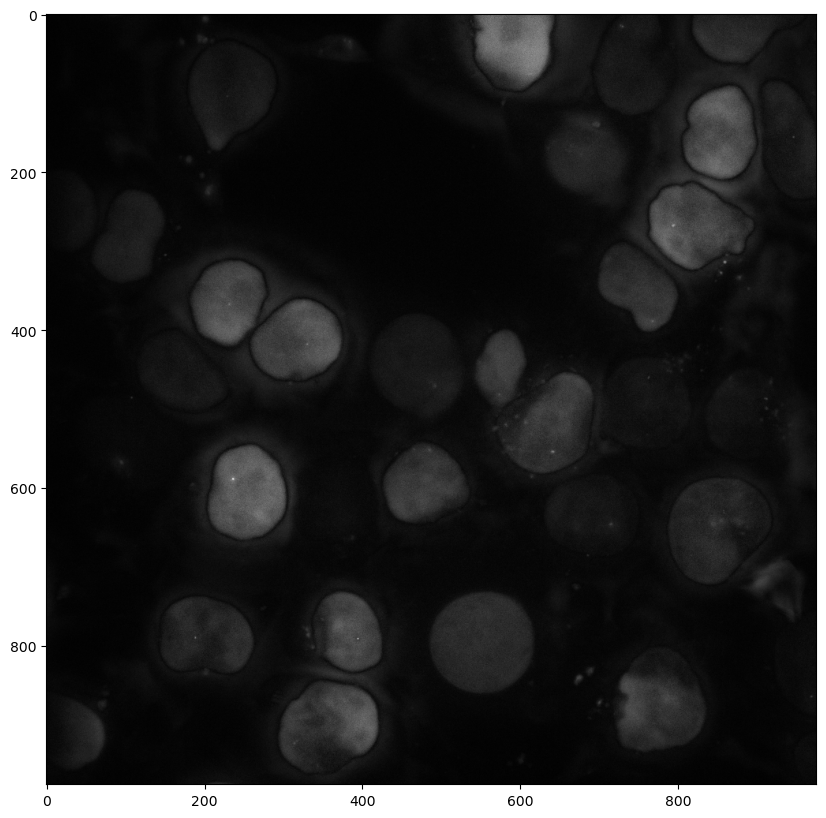

In [254]:
im_c1 = im[:, 0, ...]
im_c2 = im[:, 1, ...]
plt.figure(figsize=(10,10))
plt.imshow(np.std(im_c2[:, ...],axis=0), cmap='gray')#, vmin=416, vmax=1710)

100%|██████████| 7/7 [00:11<00:00,  1.70s/it]


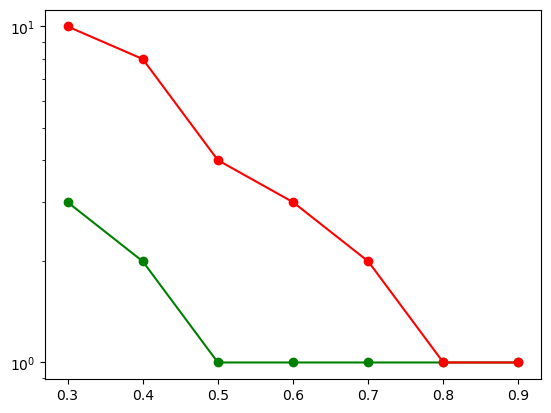

In [235]:
n_detections=[]
n_detections_2=[]

im_test=np.expand_dims(np.max(im_c1,axis=0),axis=0)
im_test_2=np.expand_dims(np.max(im_c2,axis=0),axis=0)

range_t=np.arange(0.3,0.9,0.1)
for t in tqdm(range_t):
    n_detections.append(len(pre.get_loc(im=im_test,frame=0,thresh=t,mins=1.974,maxs=3)))
    n_detections_2.append(len(pre.get_loc(im=im_test_2,frame=0,thresh=t,mins=1.974,maxs=3)))
    #print(pre.get_loc(im=im_test,frame=0,thresh=t,mins=1.974,maxs=3))
plt.plot(range_t,n_detections,"-o",c="g")
plt.plot(range_t,n_detections_2,"-o",c="r")
plt.yscale("log")
plt.show()

In [255]:
im_test=np.expand_dims(np.max(im_c1,axis=0),axis=0)
im_test_2=np.expand_dims(np.max(im_c2,axis=0),axis=0)
h = pre.compute_h_param(im=im_test,frame = 0,thresh=0.5)
h2 = pre.compute_h_param(im=im_test_2,frame = 0,thresh=0.5)
print(h,h2)

/tungstenfs/scratch/ggiorget/mattia/miniconda3/envs/Image_Analysis/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/tungstenfs/scratch/ggiorget/mattia/miniconda3/envs/Image_Analysis/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


255.64983669197818 508.7888947080319


/tungstenfs/scratch/ggiorget/mattia/miniconda3/envs/Image_Analysis/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/tungstenfs/scratch/ggiorget/mattia/miniconda3/envs/Image_Analysis/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


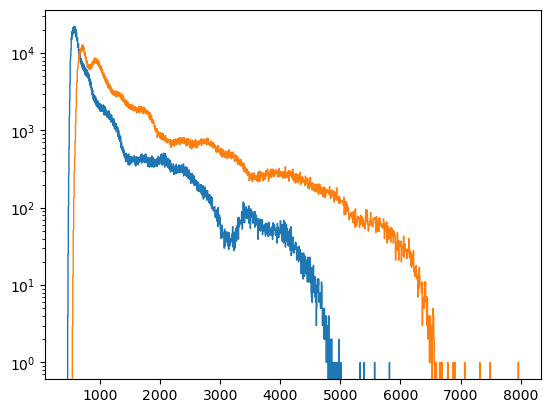

In [256]:
plt.hist(im_test.flatten(),bins=1000,histtype="step")
plt.hist(im_test_2.flatten(),bins=1000,histtype="step")
plt.yscale("log")
plt.show()

In [257]:
im_c1 = np.expand_dims(im_c1, axis=0)
im_c2 = np.expand_dims(im_c2, axis=0)

In [272]:
detections = det.hmax_3D_no_fitting(raw_im=im_c1,frame=0,sd=h,n=1.5)
detections_temp = det.hmax_3D_no_fitting(raw_im= im_c2,frame=0,sd=h2,n=1.5)

/tungstenfs/scratch/ggiorget/mattia/Image_Analysis/localization_precision_estimation/scratchpad/../ipa/src/detection_utils.py:23: UserWarning: possible precision loss converting image to floating point. To silence this warning, ensure image and h have same data type.
  im_mask = extrema.h_maxima(raw_im[frame],h=n*int(sd))


36
38


In [273]:
detections['channel'] = 1
detections_temp['channel'] = 2
detections_comb = pd.concat([detections, detections_temp])

In [274]:
detections_comb

,x,y,z,frame,channel
0,312,443,0,0,1
1,345,392,3,0,1
2,862,187,1,0,1
3,838,673,0,0,1
4,886,33,0,0,1
...,...,...,...,...,...
33,731,15,3,0,2
34,844,647,0,0,2
35,860,314,0,0,2
36,218,975,5,0,2


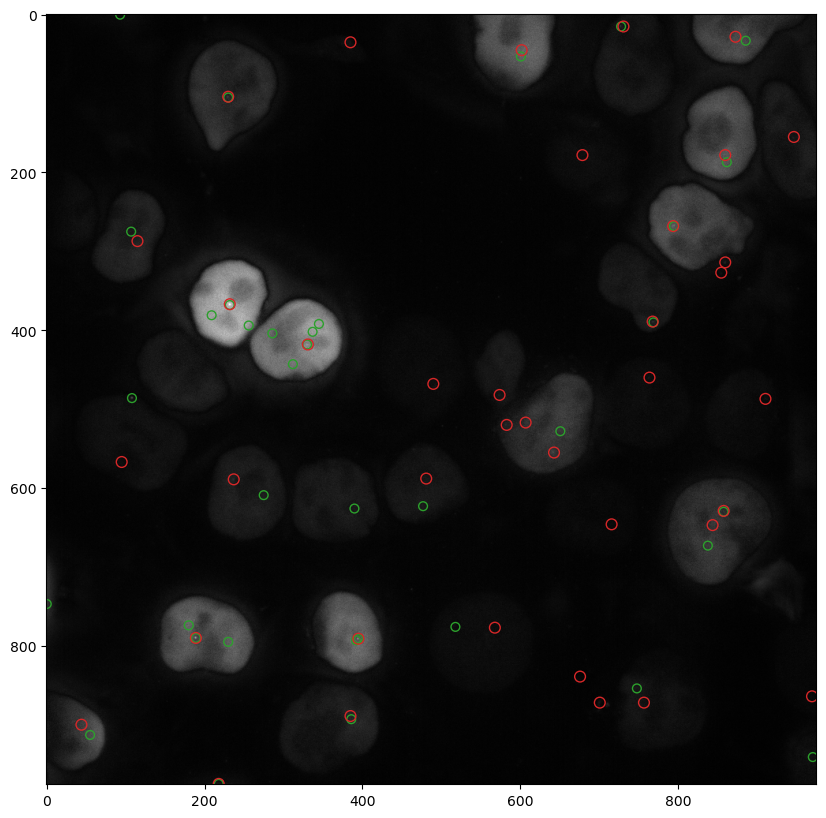

In [275]:
plt.figure(figsize=(10,10))
plt.imshow(np.std(im_c1[0, :, ...],axis=0), cmap='gray')#, vmin=416, vmax=1710)
plt.scatter(detections_comb[detections_comb.channel == 1]['x'],detections_comb[detections_comb.channel == 1]['y'], edgecolors='tab:green',facecolors='none' ,s=40)
plt.scatter(detections_comb[detections_comb.channel == 2]['x'],detections_comb[detections_comb.channel == 2]['y'], edgecolors='tab:red',facecolors='none' ,s=60)

# Matching

In [279]:
detections_comb = pd.concat([detections, detections_temp])
detections_comb['x'] = detections_comb['x']*met.voxel_size()[0]
detections_comb['y'] = detections_comb['y']*met.voxel_size()[1]
detections_comb['z'] = detections_comb['z']*met.voxel_size()[2]

In [280]:
detections_f = detections_comb
df1 = detections_f[detections_f.channel ==1]
df2 = detections_f[detections_f.channel ==2]
df1.reset_index(inplace=True)
df2.reset_index(inplace=True)
reference = df1[["x","y","z"]].values.T
moving = df2[["x","y","z"]].values.T
moving_cor = moving#np.dot(R,moving)+displacement
matched=cor.assign_closest(pd.DataFrame(reference.T,columns=["x","y","z"]),pd.DataFrame(moving_cor.T,columns=["x","y","z"]),0.3)
detections_1 = df1.copy()
detections_2 = df2.copy()
for i in matched:
    detections_1.loc[i[0],'dx'] = i[2]
    detections_1.loc[i[0],'dy'] = i[3]
    detections_1.loc[i[0],'dz'] = i[4]
    detections_2.loc[i[1],'dx'] = i[2]
    detections_2.loc[i[1],'dy'] = i[3]
    detections_2.loc[i[1],'dz'] = i[4]
detections_1.dropna(inplace=True, axis=0)
detections_2.dropna(inplace=True, axis=0)
for i in detections_1.index.unique():
    detections_1.loc[i,"x"]=detections_1.loc[i,"x"]/met.voxel_size()[0]
    detections_1.loc[i,"y"]=detections_1.loc[i,"y"]/met.voxel_size()[1]
    detections_1.loc[i,"z"]=detections_1.loc[i,"z"]/met.voxel_size()[2]
for i in detections_2.index.unique():
    detections_2.loc[i,"x"]=detections_2.loc[i,"x"]/met.voxel_size()[0]
    detections_2.loc[i,"y"]=detections_2.loc[i,"y"]/met.voxel_size()[1]
    detections_2.loc[i,"z"]=detections_2.loc[i,"z"]/met.voxel_size()[2]

In [281]:
matched

[(5, 9, 0.0, 0.13000000000000966, 0.20000000000000018),
 (11, 17, 0.13000000000000966, 0.0, 0.2),
 (12, 10, 0.0, 0.0, 0.0),
 (13, 16, 0.0, 0.13000000000000256, 0.0),
 (23, 2, 0.0, 0.13000000000000078, 0.0),
 (31, 18, -0.13000000000000256, 0.0, 0.0),
 (32, 24, 0.12999999999999545, 0.13000000000000256, -0.19999999999999996),
 (34, 21, 0.0, 0.0, -0.20000000000000018)]

In [265]:
detections_2

,index,x,y,z,frame,channel,dx,dy,dz
5,5,230.0,104.0,8.0,0,2,-0.001895,0.131263,0.000566
17,17,858.0,629.0,13.0,0,2,0.000474,0.128373,0.204416
19,19,395.0,791.0,13.0,0,2,0.001243,0.000574,-0.005242
27,27,108.0,486.0,1.0,0,2,0.000098,0.001709,-0.006194
28,28,232.0,367.0,3.0,0,2,-0.000518,0.131158,-0.002668
32,32,794.0,268.0,0.0,0,2,0.129088,-0.001572,0.207843
33,33,331.0,418.0,10.0,0,2,-0.130454,0.000821,-0.001666
37,37,189.0,790.0,12.0,0,2,0.001264,0.001534,-0.208632
40,40,768.0,389.0,7.0,0,2,0.129485,0.128686,-0.194089


In [266]:
fit_1=det.fitting(im_c1,frame=0,detected_spot=detections_1,thresh=0.5,threads=1)
fit_2=det.fitting(im_c2,frame=0,detected_spot=detections_2,thresh=0.5,threads=1)
fit_1['channel'] = 1
fit_2['channel'] = 2
detections_comb_fitted = pd.concat([fit_1,fit_2])
detections_comb_fitted['x'] = detections_comb_fitted['x']*met.voxel_size()[0]
detections_comb_fitted['y'] = detections_comb_fitted['y']*met.voxel_size()[1]
detections_comb_fitted['z'] = detections_comb_fitted['z']*met.voxel_size()[2]

In [267]:
detections_f = detections_comb_fitted
df1 = detections_f[detections_f.channel ==1]
df2 = detections_f[detections_f.channel ==2]
df1.reset_index(inplace=True)
df2.reset_index(inplace=True)
reference = df1[["x","y","z"]].values.T
moving = df2[["x","y","z"]].values.T
moving_cor = moving#np.dot(R,moving)+displacement
#matched=cor.assign_closest(pd.DataFrame(reference.T,columns=["x","y","z"]),pd.DataFrame(moving_cor.T,columns=["x","y","z"]),0.3)

In [270]:
moving_cor = moving
matched=cor.assign_closest(pd.DataFrame(reference.T,columns=["x","y","z"]),pd.DataFrame(moving_cor.T,columns=["x","y","z"]),0.3)
print(matched)

[(0, 3, -0.025948511994329237, -0.022489644106300943, -0.025017665809562217), (1, 2, 0.00787957245083959, 0.20736870460108925, 0.011732553301381676), (3, 1, -0.007228402288262714, 0.13189961101633685, 0.21348958898331993), (5, 6, 0.03660396975016056, 0.033636718530303256, 0.0360299157056897), (6, 4, 0.13347128856581492, 0.04288212204895103, -0.2102911851056226)]


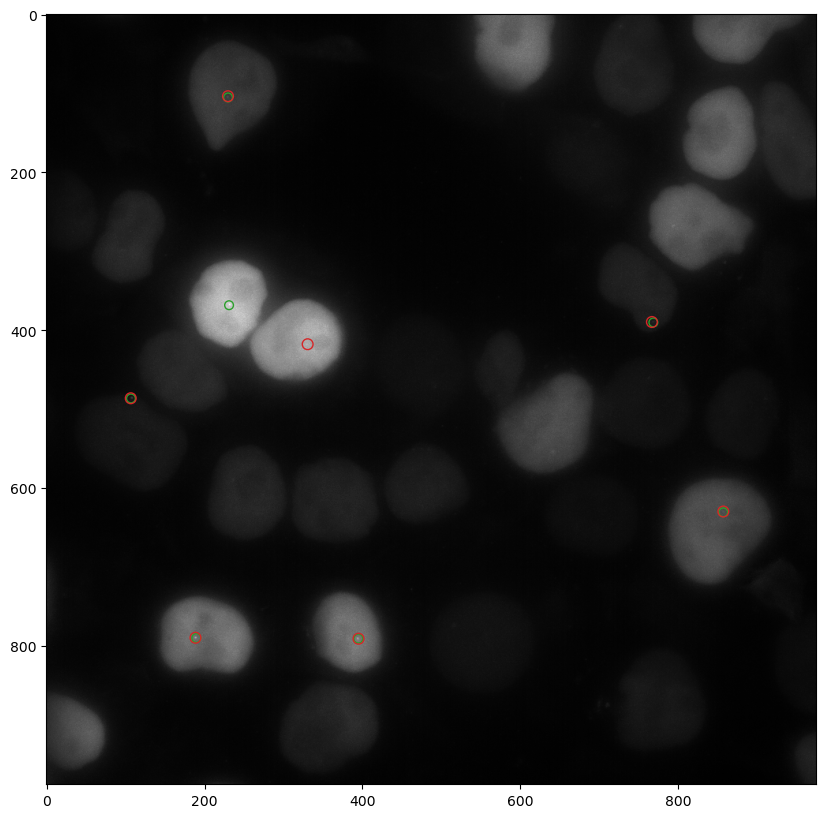

In [271]:
fit_1['channel'] = 1
fit_2['channel'] = 2
detections_comb_fitted = pd.concat([fit_1,fit_2])
plt.figure(figsize=(10,10))
plt.imshow(np.max(im_c1[0, :, ...],axis=0), cmap='gray')#, vmin=416, vmax=1710)
#plt.scatter(detections_comb[detections_comb.channel == 1]['x'],detections_comb[detections_comb.channel == 1]['y'], edgecolors='blue',facecolors='none' ,s=40)
#plt.scatter(detections_comb[detections_comb.channel == 2]['x'],detections_comb[detections_comb.channel == 2]['y'], edgecolors='orange',facecolors='none' ,s=60)
plt.scatter(detections_comb_fitted[detections_comb_fitted.channel == 1]['x'],detections_comb_fitted[detections_comb_fitted.channel == 1]['y'], edgecolors='tab:green',facecolors='none' ,s=40)
plt.scatter(detections_comb_fitted[detections_comb_fitted.channel == 2]['x'],detections_comb_fitted[detections_comb_fitted.channel == 2]['y'], edgecolors='tab:red',facecolors='none' ,s=60)

In [41]:
for i in detections_1.index.unique():
    detections_1.loc[i,"x"]=detections_1.loc[i,"x"]/met.voxel_size()[0]
    detections_1.loc[i,"y"]=detections_1.loc[i,"y"]/met.voxel_size()[1]
    detections_1.loc[i,"z"]=detections_1.loc[i,"z"]/met.voxel_size()[2]
for i in detections_2.index.unique():
    detections_2.loc[i,"x"]=detections_2.loc[i,"x"]/met.voxel_size()[0]
    detections_2.loc[i,"y"]=detections_2.loc[i,"y"]/met.voxel_size()[1]
    detections_2.loc[i,"z"]=detections_2.loc[i,"z"]/met.voxel_size()[2]

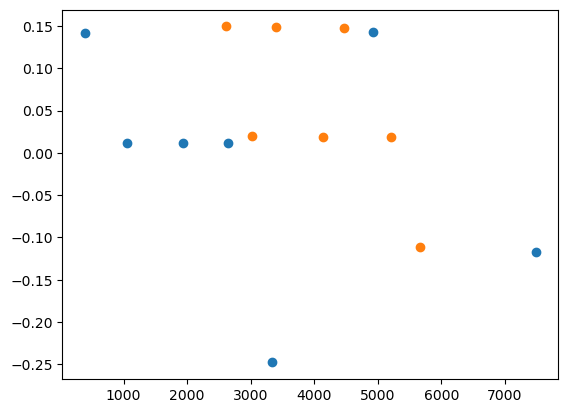

In [42]:
dx=detections_1["dx"].values
x=detections_1["x"]
plt.scatter(detections_1["x"],detections_1["dx"].values)
plt.scatter(detections_1["y"],detections_1["dy"].values)
#plt.scatter(detections_1["z"],detections_1["dz"].values)

In [43]:
big_error=detections_1[np.abs(detections_1["dy"].values)<1]


In [44]:
big_error

,index,x,y,z,frame,channel,dx,dy,dz
6,6,392.307692,3023.076923,5.0,0,1,0.141968,0.019411,0.250505
7,7,1053.846154,2607.692308,15.0,0,1,0.011796,0.149328,0.253909
34,34,3338.461538,5207.692308,35.0,0,1,-0.247852,0.018987,0.055241
66,66,2638.461538,4130.769231,10.0,0,1,0.012123,0.018989,0.055505
76,76,7484.615385,4469.230769,0.0,0,1,-0.117722,0.147890,0.071518
93,93,4930.769231,5669.230769,0.0,0,1,0.142495,-0.111530,-0.140507
99,99,1930.769231,3392.307692,15.0,0,1,0.011882,0.149201,-0.145048


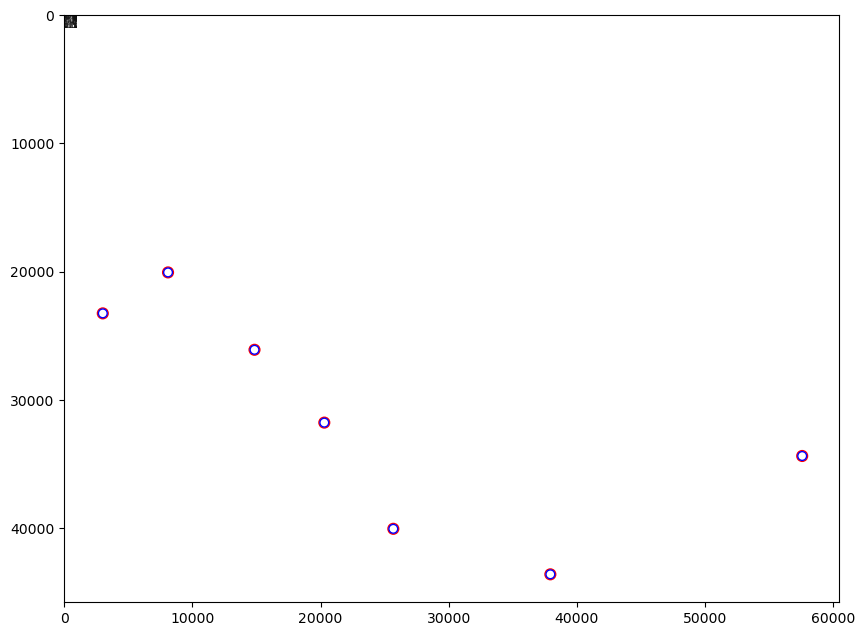

In [45]:
plt.figure(figsize=(10,10))
plt.imshow(np.max(im_c2[0, :, ...],axis=0), cmap='gray', vmin=106, vmax=8010)
plt.scatter(big_error['x']/met.voxel_size()[0],big_error['y']/met.voxel_size()[1], edgecolors='r',facecolors='none' ,s=60)
plt.scatter(big_error['x']/met.voxel_size()[0]+big_error['dx']/met.voxel_size()[0],big_error['y']/met.voxel_size()[1]+big_error['dy']/met.voxel_size()[1], edgecolors='blue',facecolors='none' ,s=40)

In [169]:
d=np.sqrt(detections_1["dx"].values**2+detections_1["dy"].values**2+detections_1["dz"].values**2)


In [173]:
detections_1["dy"]

11    0.119186
16    0.074489
Name: dy, dtype: float64